# Introduction
**Author:** Samanyu K<br>
**Language:** Python<br>
**Accelerator:** None<br>

In [131]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.stattools import acf,pacf,adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [132]:
df=pd.read_csv(r'/kaggle/input/air-passenger-data-for-time-series-analysis/AirPassengers.csv')
print(df.head(4),df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129 None


In [133]:
print(df['Month'].max(),df['Month'].min())

1960-12 1949-01


In [134]:
# We have Monthly data from 1949 to 1960, a total of 12 years. Total data points is (12 Months *12 Years=144)
# Let us standardize this a bit
df['Month']=pd.to_datetime(df['Month'],infer_datetime_format=True)
df=df.rename(columns={'#Passengers':'Passenger'})
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Month      144 non-null    datetime64[ns]
 1   Passenger  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB
None


/tmp/ipykernel_35/1690156315.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Month']=pd.to_datetime(df['Month'],infer_datetime_format=True)


In [135]:
# Let us plit the dataset into Train and Test 
train_size = 132
test_size = 12

tr = df.iloc[:train_size].copy()
te = df.iloc[train_size:train_size + test_size].copy()

print(tr.shape, te.shape)


(132, 2) (12, 2)


In [136]:
tr.set_index('Month',inplace=True,drop=True)
te.set_index('Month',inplace=True,drop=True)
print(tr.info(),te.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 1949-01-01 to 1959-12-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Passenger  132 non-null    int64
dtypes: int64(1)
memory usage: 2.1 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 1960-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Passenger  12 non-null     int64
dtypes: int64(1)
memory usage: 192.0 bytes
None None


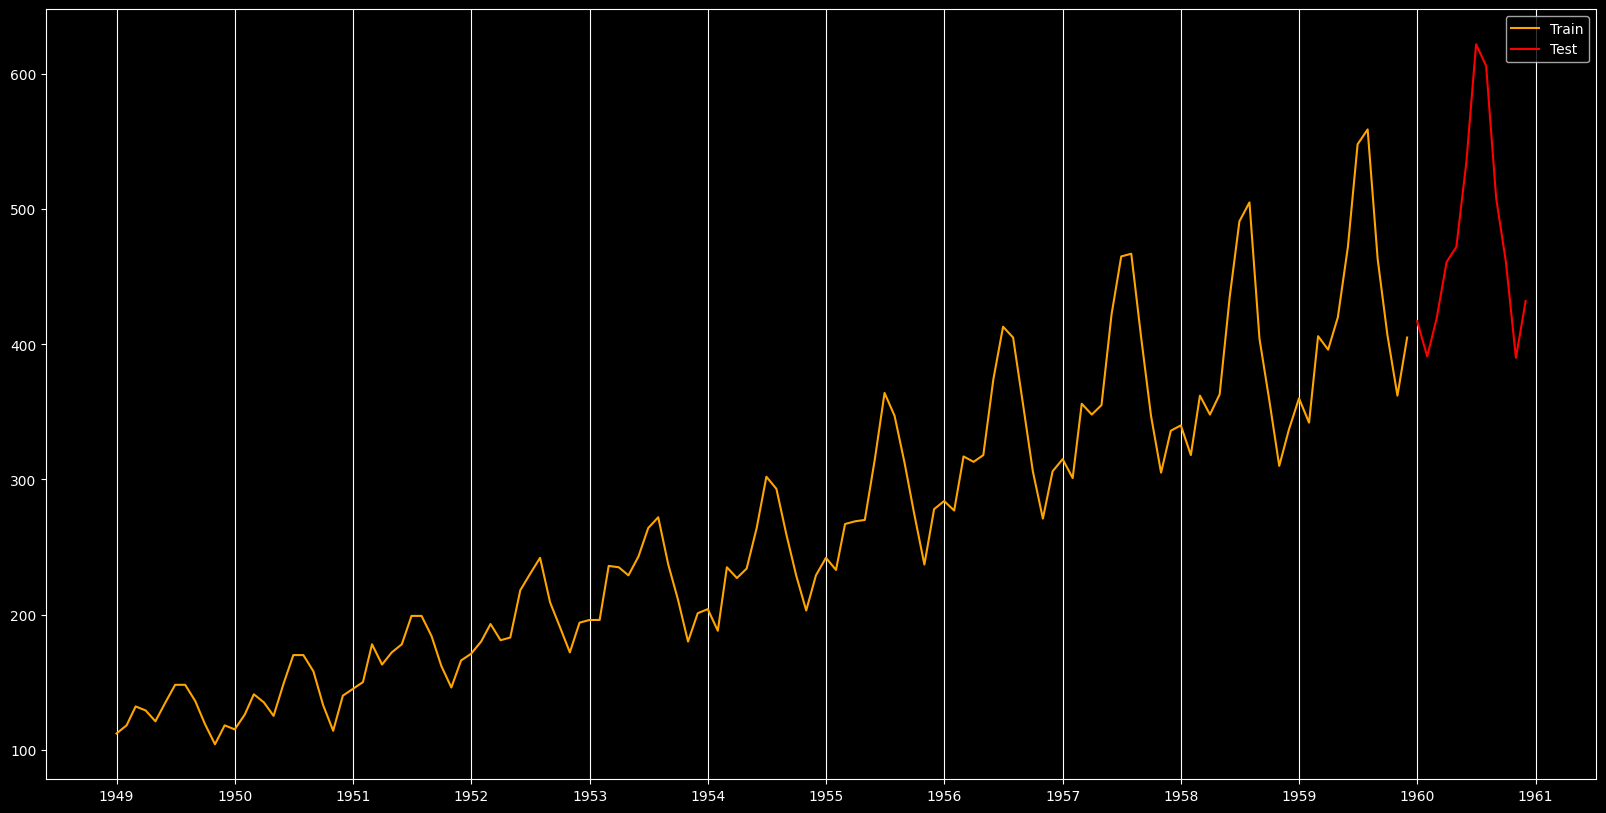

In [137]:
plt.style.use('dark_background')
plt.figure(figsize=(20,10))
plt.plot(tr['Passenger'],color='orange')
plt.plot(te['Passenger'],color='red')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(axis='x')
plt.legend(['Train','Test'])
plt.show()

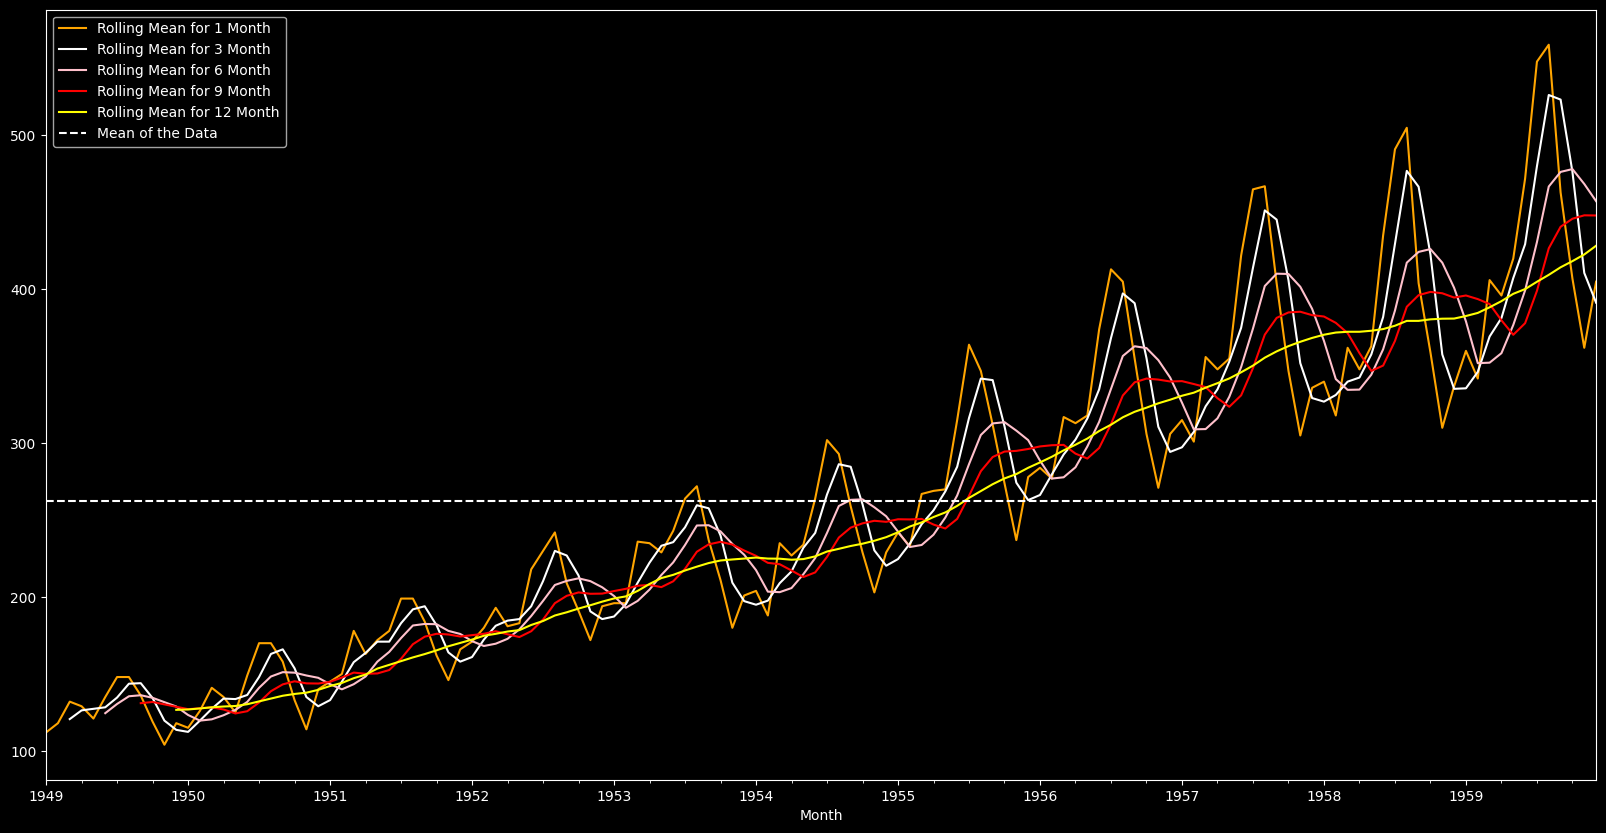

In [138]:
plt.figure(figsize=(20,10))
tr['Passenger'].rolling(1).mean().plot(label='Rolling Mean for 1 Month', color='orange')
tr['Passenger'].rolling(3).mean().plot(label='Rolling Mean for 3 Month', color='white')
tr['Passenger'].rolling(6).mean().plot(label='Rolling Mean for 6 Month', color='pink')
tr['Passenger'].rolling(9).mean().plot(label='Rolling Mean for 9 Month', color='red')
tr['Passenger'].rolling(12).mean().plot(label='Rolling Mean for 12 Month', color='yellow')
plt.axhline(tr['Passenger'].mean(), linestyle='--', label='Mean of the Data')
plt.legend()
plt.show()


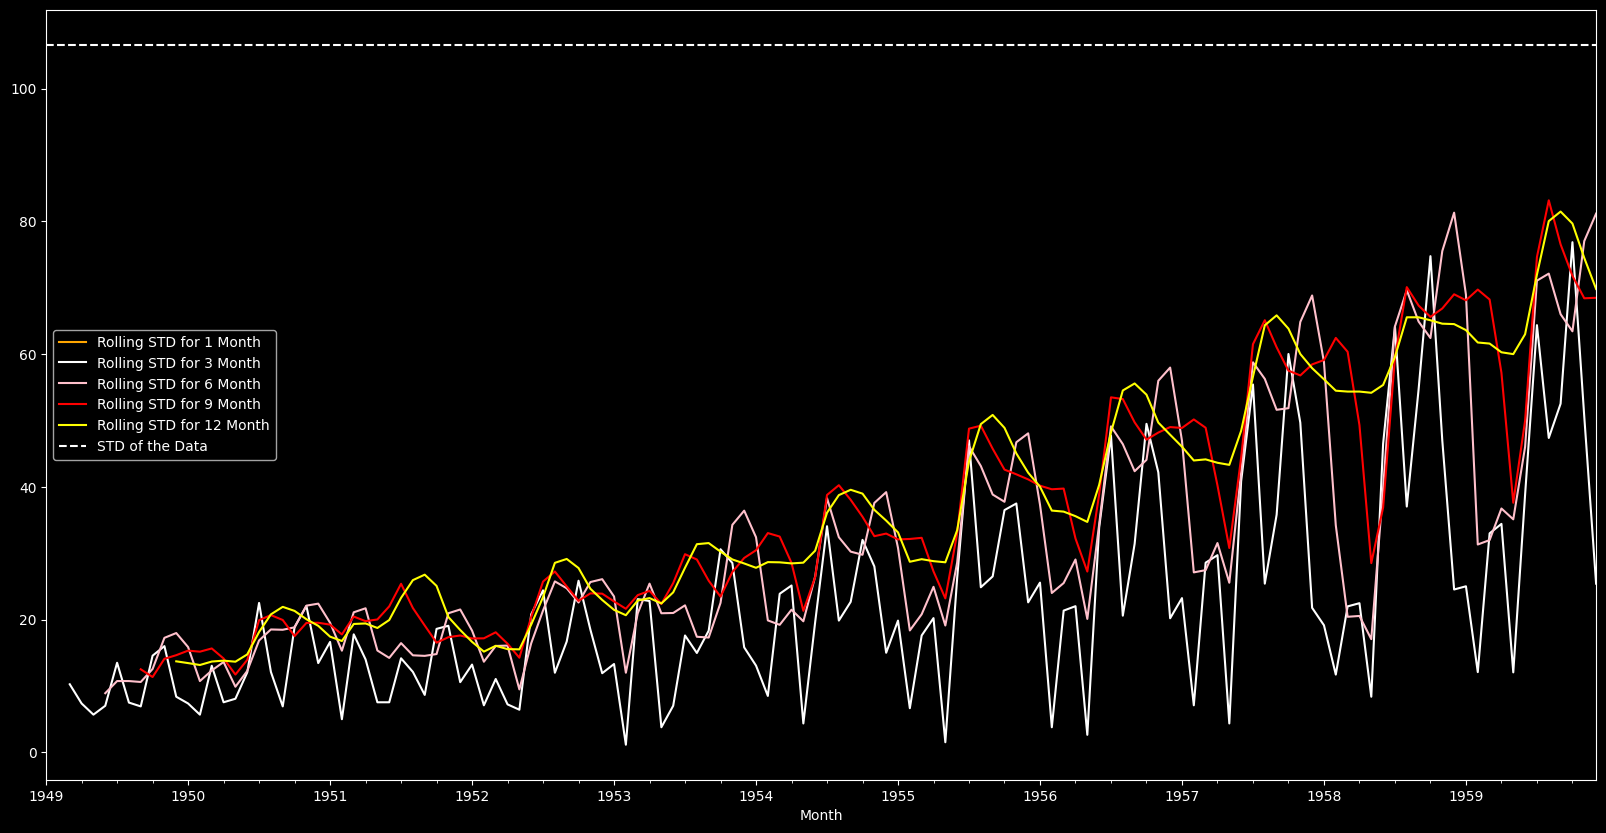

In [139]:
plt.figure(figsize=(20,10))
tr['Passenger'].rolling(1).std().plot(label='Rolling STD for 1 Month', color='orange')
tr['Passenger'].rolling(3).std().plot(label='Rolling STD for 3 Month', color='white')
tr['Passenger'].rolling(6).std().plot(label='Rolling STD for 6 Month', color='pink')
tr['Passenger'].rolling(9).std().plot(label='Rolling STD for 9 Month', color='red')
tr['Passenger'].rolling(12).std().plot(label='Rolling STD for 12 Month', color='yellow')
plt.axhline(tr['Passenger'].std(), linestyle='--', label='STD of the Data')
plt.legend()
plt.show()

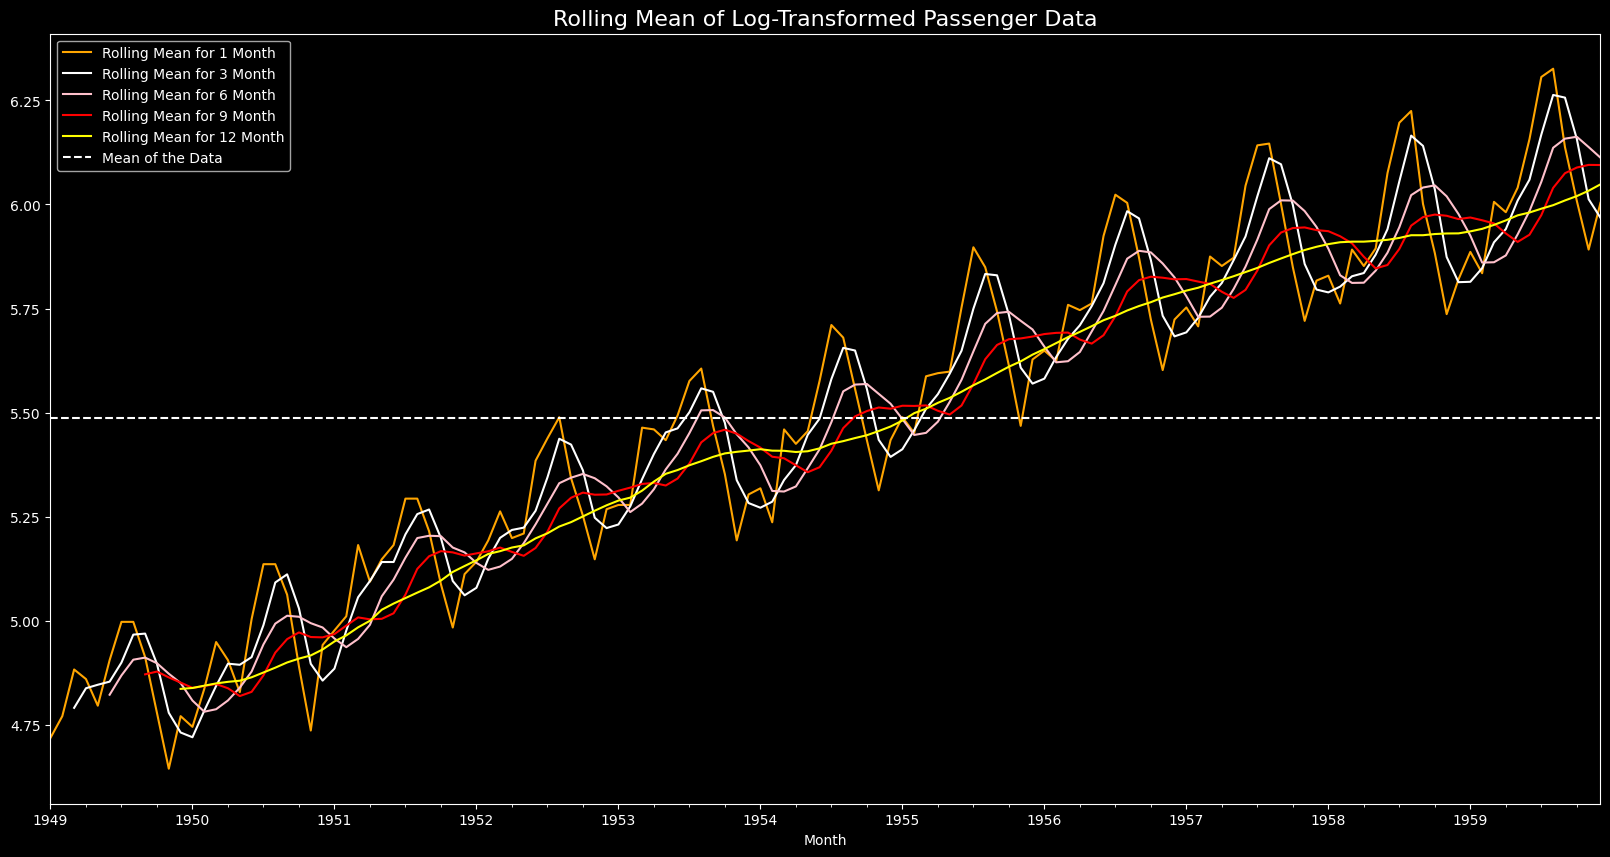

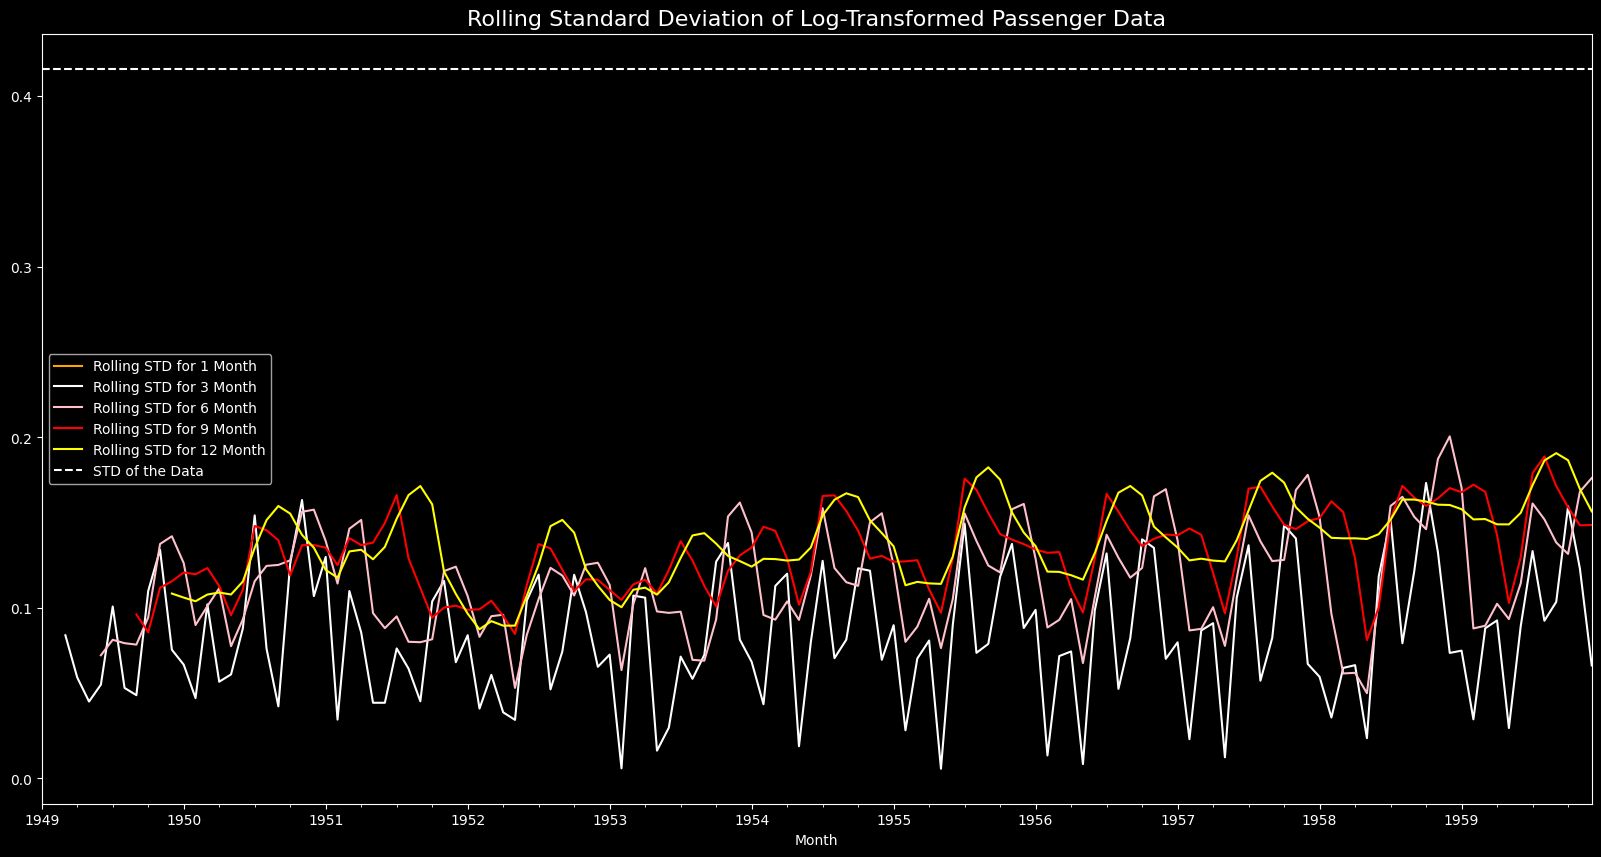

In [140]:
# Apply log transform to both train and test sets
tr['Passenger_log'] = np.log(tr['Passenger'])
te['Passenger_log'] = np.log(te['Passenger'])
plt.figure(figsize=(20,10))
tr['Passenger_log'].rolling(1).mean().plot(label='Rolling Mean for 1 Month', color='orange')
tr['Passenger_log'].rolling(3).mean().plot(label='Rolling Mean for 3 Month', color='white')
tr['Passenger_log'].rolling(6).mean().plot(label='Rolling Mean for 6 Month', color='pink')
tr['Passenger_log'].rolling(9).mean().plot(label='Rolling Mean for 9 Month', color='red')
tr['Passenger_log'].rolling(12).mean().plot(label='Rolling Mean for 12 Month', color='yellow')
plt.axhline(tr['Passenger_log'].mean(), linestyle='--', label='Mean of the Data')
plt.title("Rolling Mean of Log-Transformed Passenger Data", fontsize=16)
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
tr['Passenger_log'].rolling(1).std().plot(label='Rolling STD for 1 Month', color='orange')
tr['Passenger_log'].rolling(3).std().plot(label='Rolling STD for 3 Month', color='white')
tr['Passenger_log'].rolling(6).std().plot(label='Rolling STD for 6 Month', color='pink')
tr['Passenger_log'].rolling(9).std().plot(label='Rolling STD for 9 Month', color='red')
tr['Passenger_log'].rolling(12).std().plot(label='Rolling STD for 12 Month', color='yellow')
plt.axhline(tr['Passenger_log'].std(), linestyle='--', label='STD of the Data')
plt.title("Rolling Standard Deviation of Log-Transformed Passenger Data", fontsize=16)
plt.legend()
plt.show()


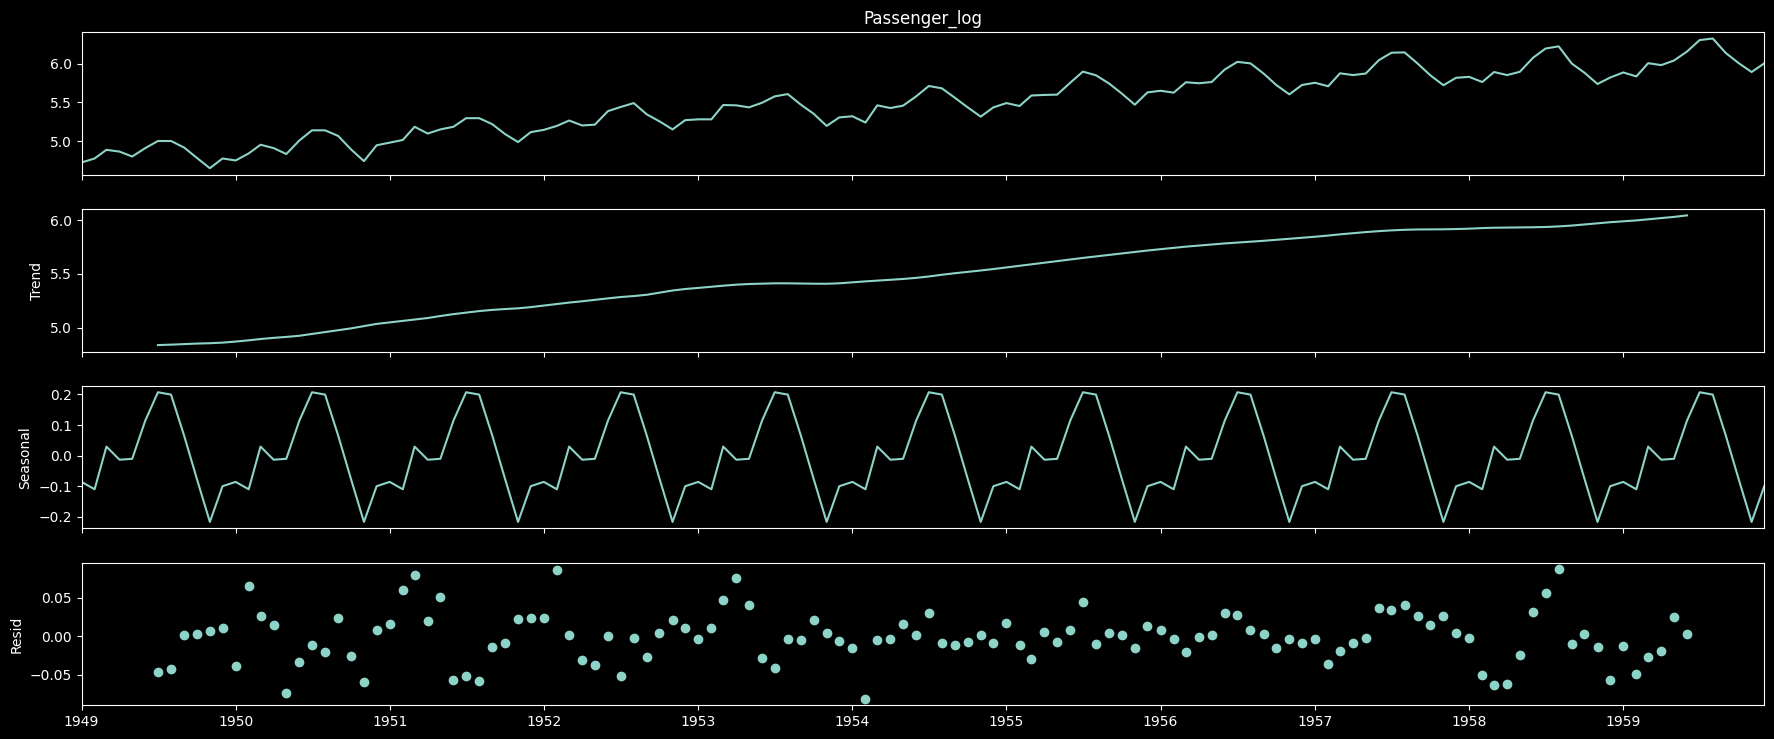

In [141]:
decomposition = seasonal_decompose(tr['Passenger_log'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(20, 8)  
plt.show()

In [142]:
adf_result = adfuller(tr['Passenger_log'])
print("===== ADF Test =====")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
if adf_result[1] <= 0.05:
    print("Stationary (likely), reject null hypothesis")
else:
    print("Not stationary, fail to reject null hypothesis")

===== ADF Test =====
ADF Statistic: -1.3176112021439923
p-value: 0.6210771494355892
Not stationary, fail to reject null hypothesis


In [143]:
ttr = tr.copy()

for i in np.arange(1, 10, 1):
    ttr[f'diff{i}'] = ttr['Passenger_log'].diff(i)  
    adf_result = adfuller(ttr[f'diff{i}'].dropna())  
    print(f"===== ADF Test for diff order {i} =====")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    if adf_result[1] <= 0.05:
        print("Stationary (likely), reject null hypothesis")
    else:
        print("Not stationary, fail to reject null hypothesis")


===== ADF Test for diff order 1 =====
ADF Statistic: -3.064713140773087
p-value: 0.02927719697660508
Stationary (likely), reject null hypothesis
===== ADF Test for diff order 2 =====
ADF Statistic: -2.941385095771114
p-value: 0.04074280397922317
Stationary (likely), reject null hypothesis
===== ADF Test for diff order 3 =====
ADF Statistic: -2.536313027616512
p-value: 0.10688706827193178
Not stationary, fail to reject null hypothesis
===== ADF Test for diff order 4 =====
ADF Statistic: -2.9720517934368047
p-value: 0.03758813110506562
Stationary (likely), reject null hypothesis
===== ADF Test for diff order 5 =====
ADF Statistic: -3.0426981092871426
p-value: 0.0310947909176094
Stationary (likely), reject null hypothesis
===== ADF Test for diff order 6 =====
ADF Statistic: -2.9921245213296537
p-value: 0.03563644512736575
Stationary (likely), reject null hypothesis
===== ADF Test for diff order 7 =====
ADF Statistic: -3.1044833762188295
p-value: 0.026223172800392294
Stationary (likely), r

In [144]:
ttr

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Passenger,Passenger_log,diff1,diff2,diff3,diff4,diff5,diff6,diff7,diff8,diff9
Month,,,,,,,,,,,
1949-01-01,112,4.718499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-02-01,118,4.770685,0.052186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-03-01,132,4.882802,0.112117,0.164303,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-04-01,129,4.859812,-0.022990,0.089128,0.141314,NaN,NaN,NaN,NaN,NaN,NaN
1949-05-01,121,4.795791,-0.064022,-0.087011,0.025106,0.077292,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1959-08-01,559,6.326149,0.019874,0.169170,0.285895,0.344735,0.319796,0.491339,0.440045,0.506067,0.589577
1959-09-01,463,6.137727,-0.188422,-0.168548,-0.019252,0.097472,0.156313,0.131374,0.302916,0.251623,0.317644
1959-10-01,407,6.008813,-0.128914,-0.317336,-0.297462,-0.148166,-0.031442,0.027399,0.002460,0.174002,0.122709


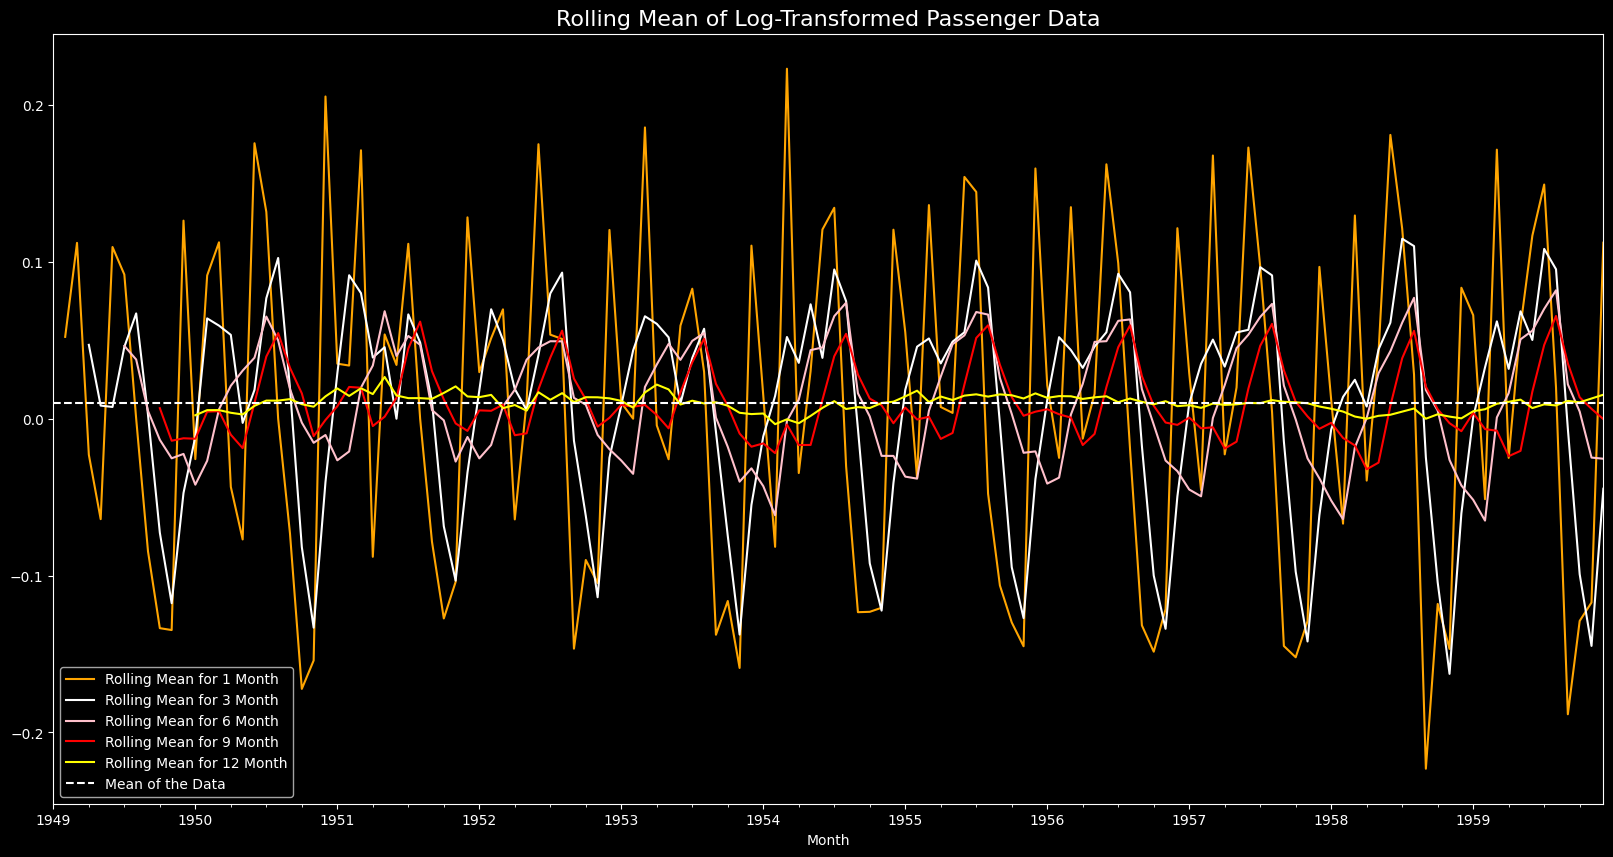

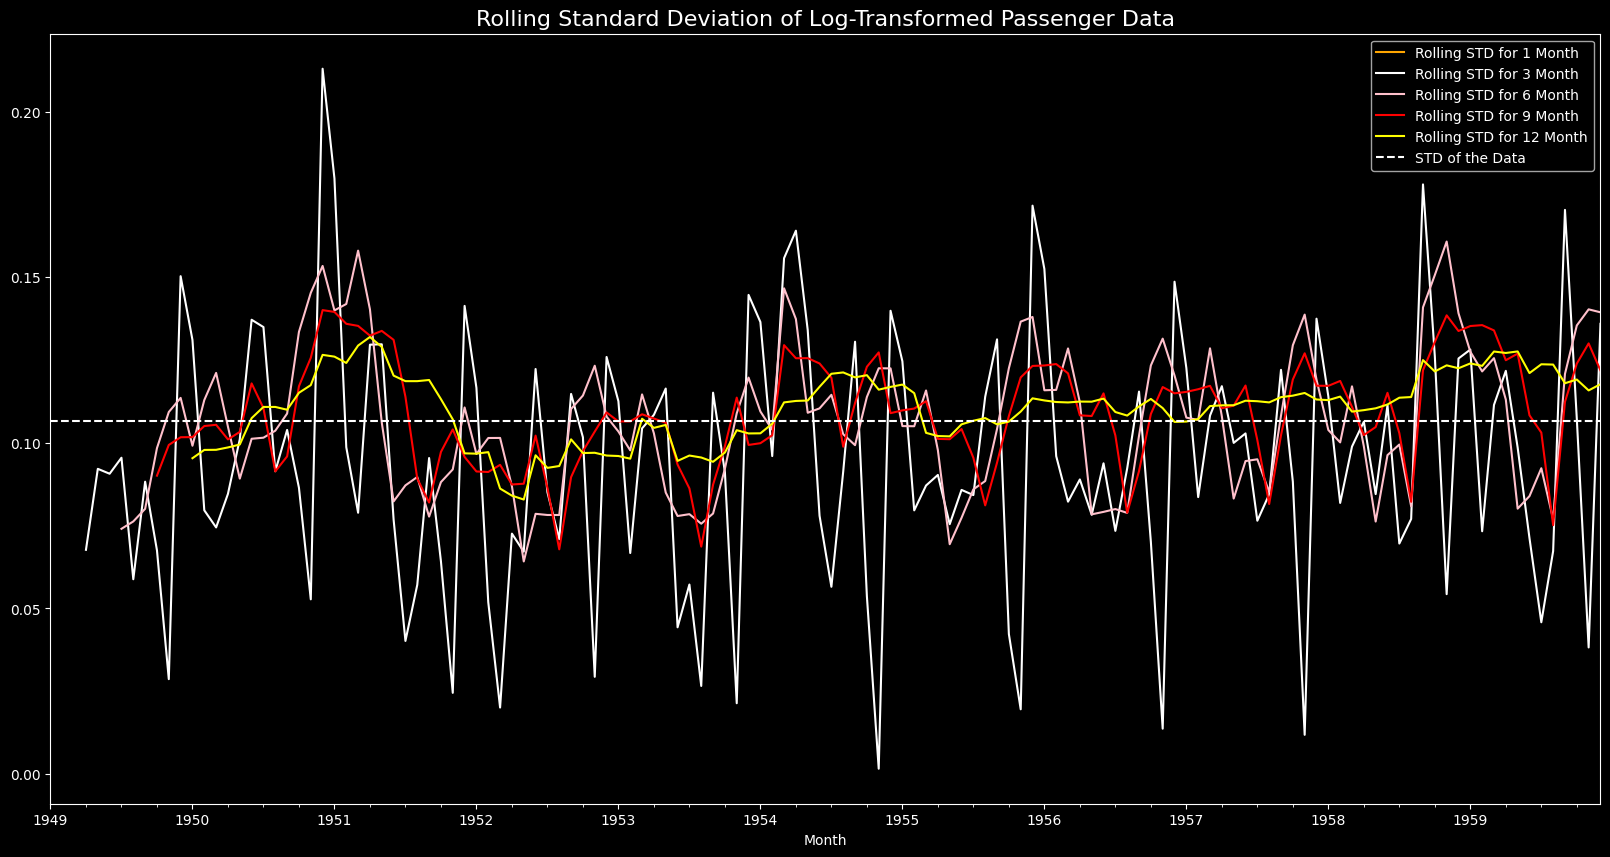

In [145]:
# One diff makes it stationary (monstly, but there still is stationarity)

ttr['diff1'].dropna(inplace=True)
plt.figure(figsize=(20,10))
ttr['diff1'].rolling(1).mean().plot(label='Rolling Mean for 1 Month', color='orange')
ttr['diff1'].rolling(3).mean().plot(label='Rolling Mean for 3 Month', color='white')
ttr['diff1'].rolling(6).mean().plot(label='Rolling Mean for 6 Month', color='pink')
ttr['diff1'].rolling(9).mean().plot(label='Rolling Mean for 9 Month', color='red')
ttr['diff1'].rolling(12).mean().plot(label='Rolling Mean for 12 Month', color='yellow')
plt.axhline(ttr['diff1'].mean(), linestyle='--', label='Mean of the Data')
plt.title("Rolling Mean of Log-Transformed Passenger Data", fontsize=16)
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
ttr['diff1'].rolling(1).std().plot(label='Rolling STD for 1 Month', color='orange')
ttr['diff1'].rolling(3).std().plot(label='Rolling STD for 3 Month', color='white')
ttr['diff1'].rolling(6).std().plot(label='Rolling STD for 6 Month', color='pink')
ttr['diff1'].rolling(9).std().plot(label='Rolling STD for 9 Month', color='red')
ttr['diff1'].rolling(12).std().plot(label='Rolling STD for 12 Month', color='yellow')
plt.axhline(ttr['diff1'].std(), linestyle='--', label='STD of the Data')
plt.title("Rolling Standard Deviation of Log-Transformed Passenger Data", fontsize=16)
plt.legend()
plt.show()


In [146]:
tr.drop(columns=['Passenger'], inplace=True)
te.drop(columns=['Passenger'], inplace=True)

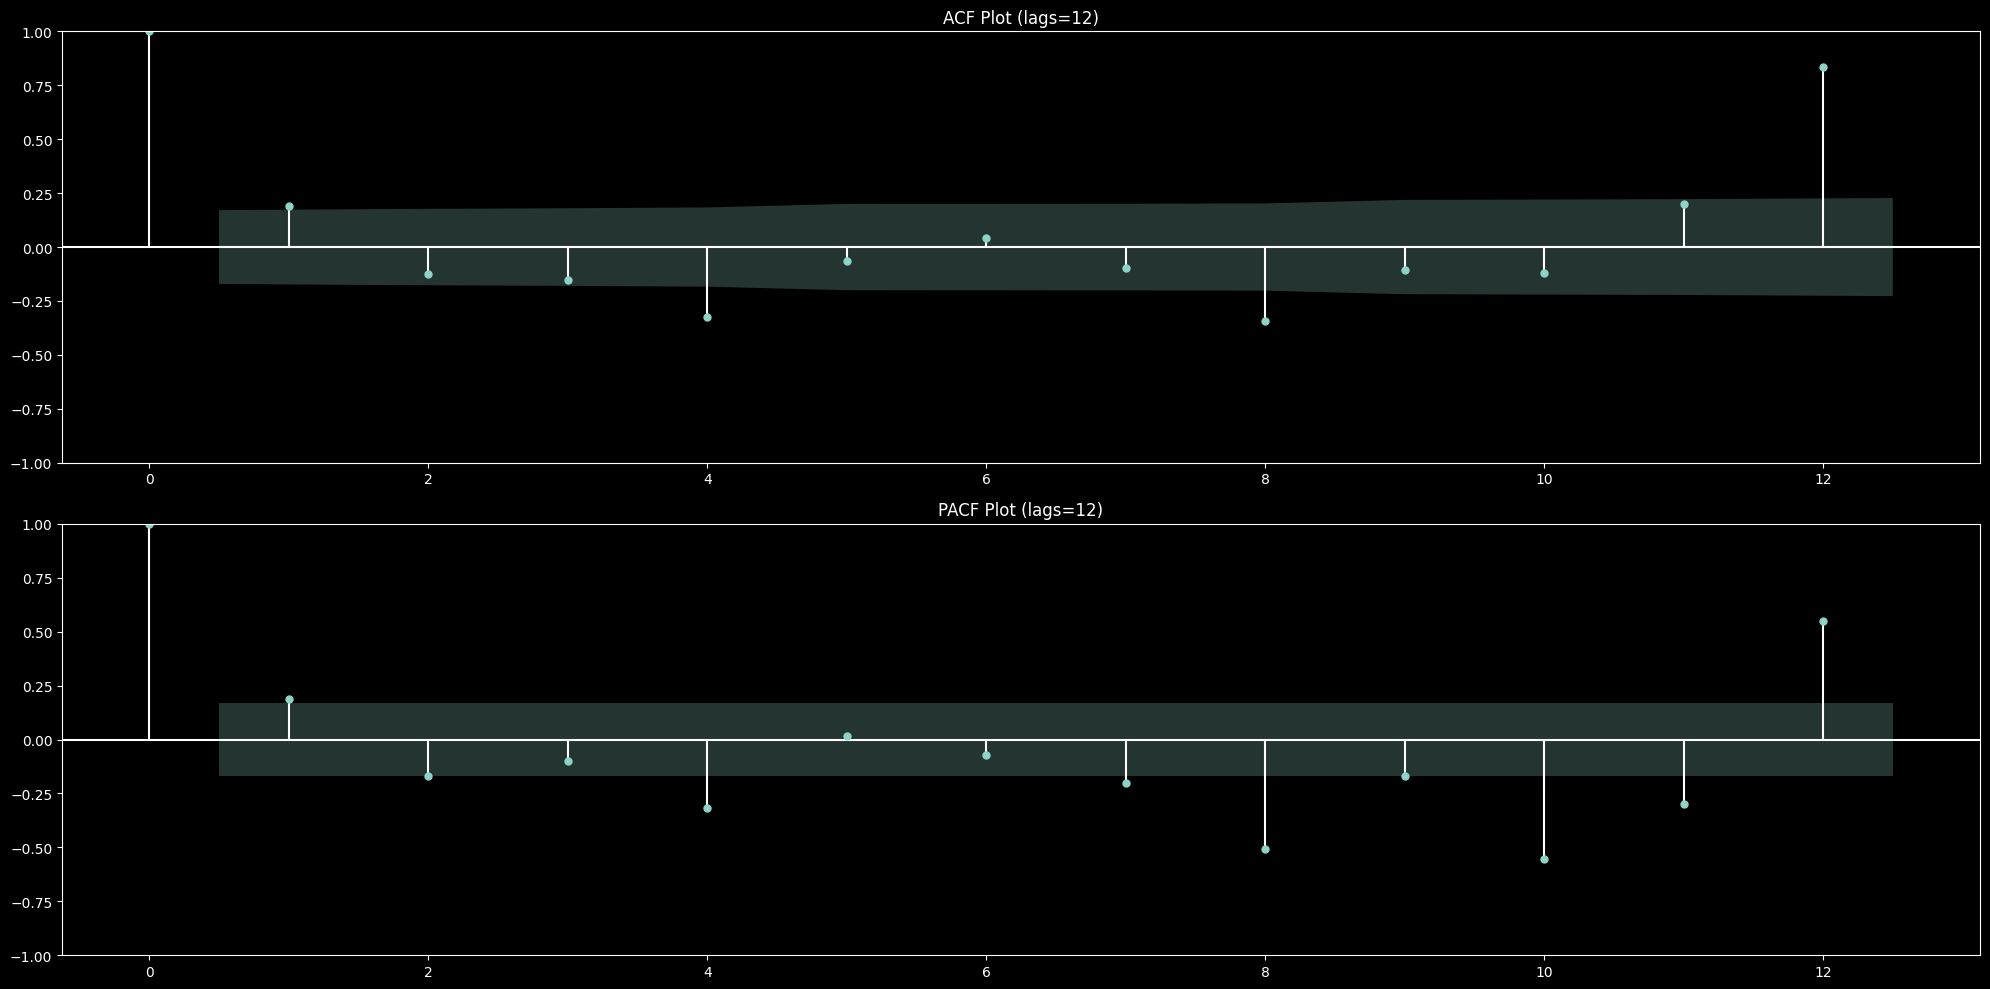

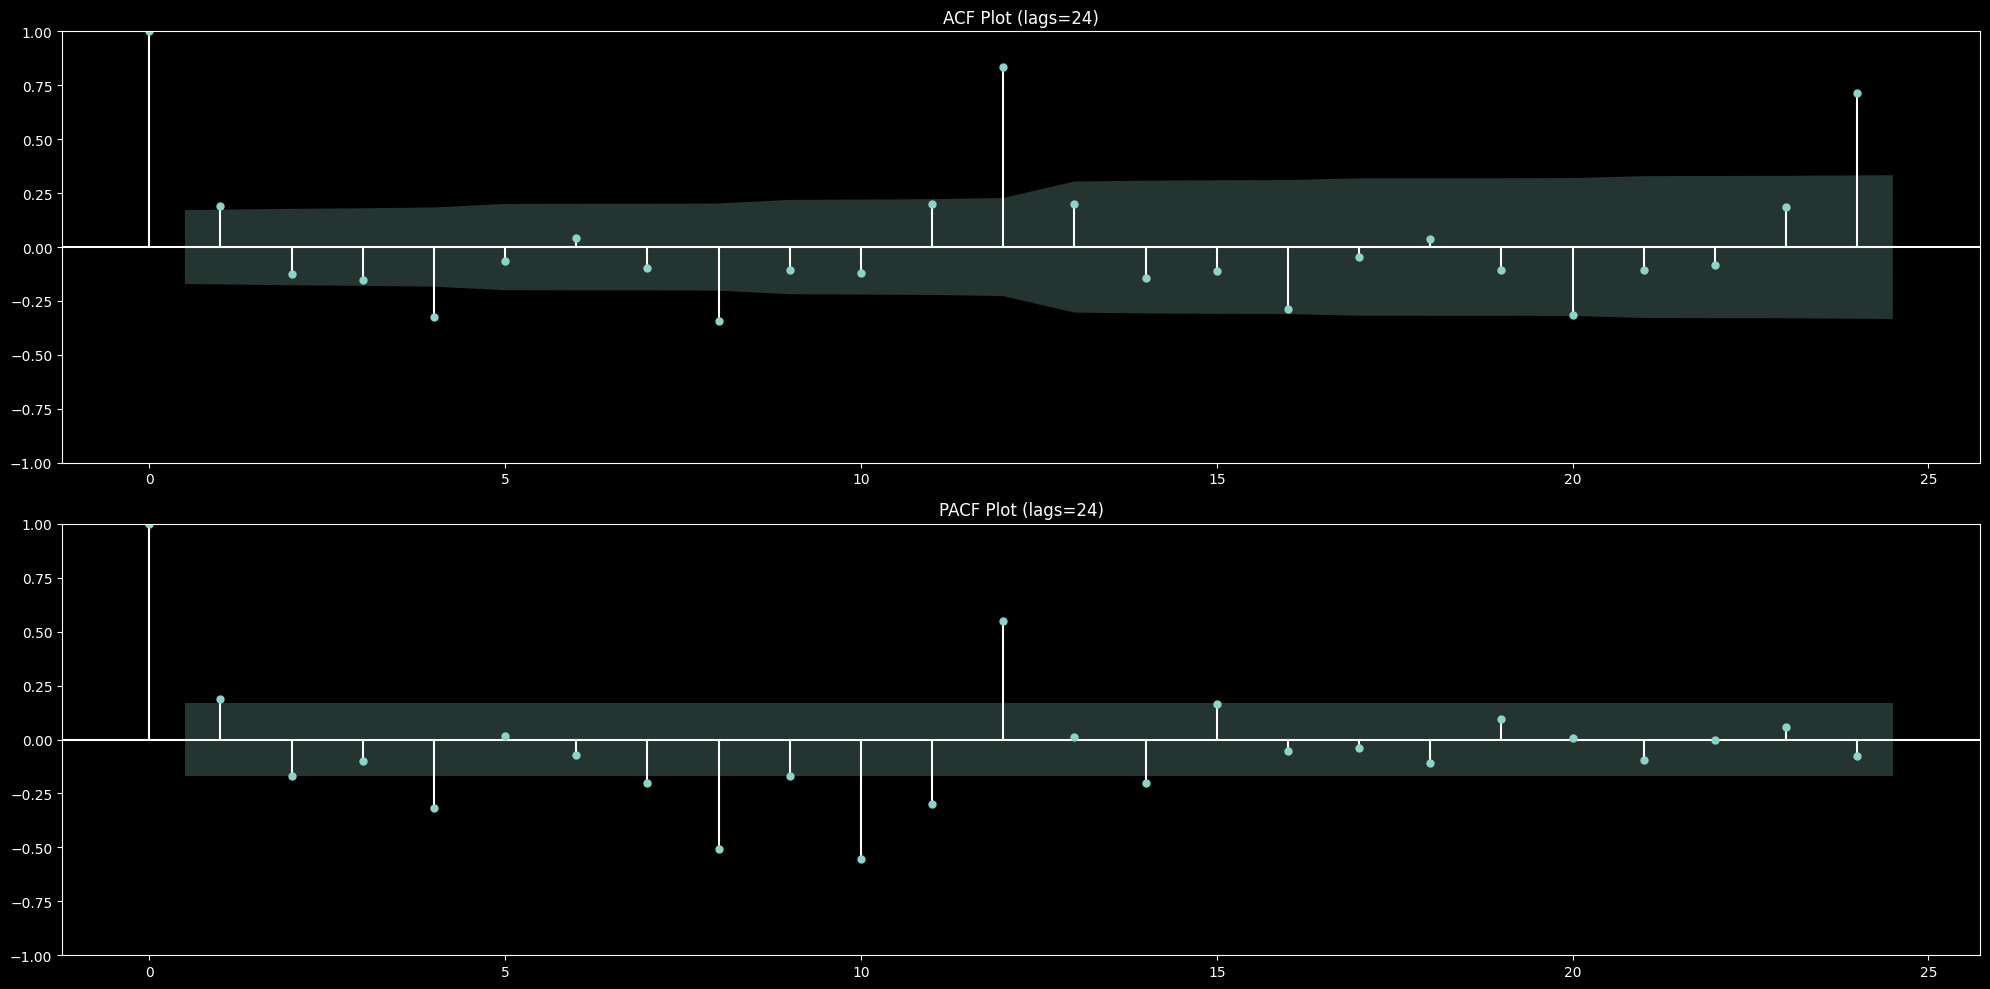

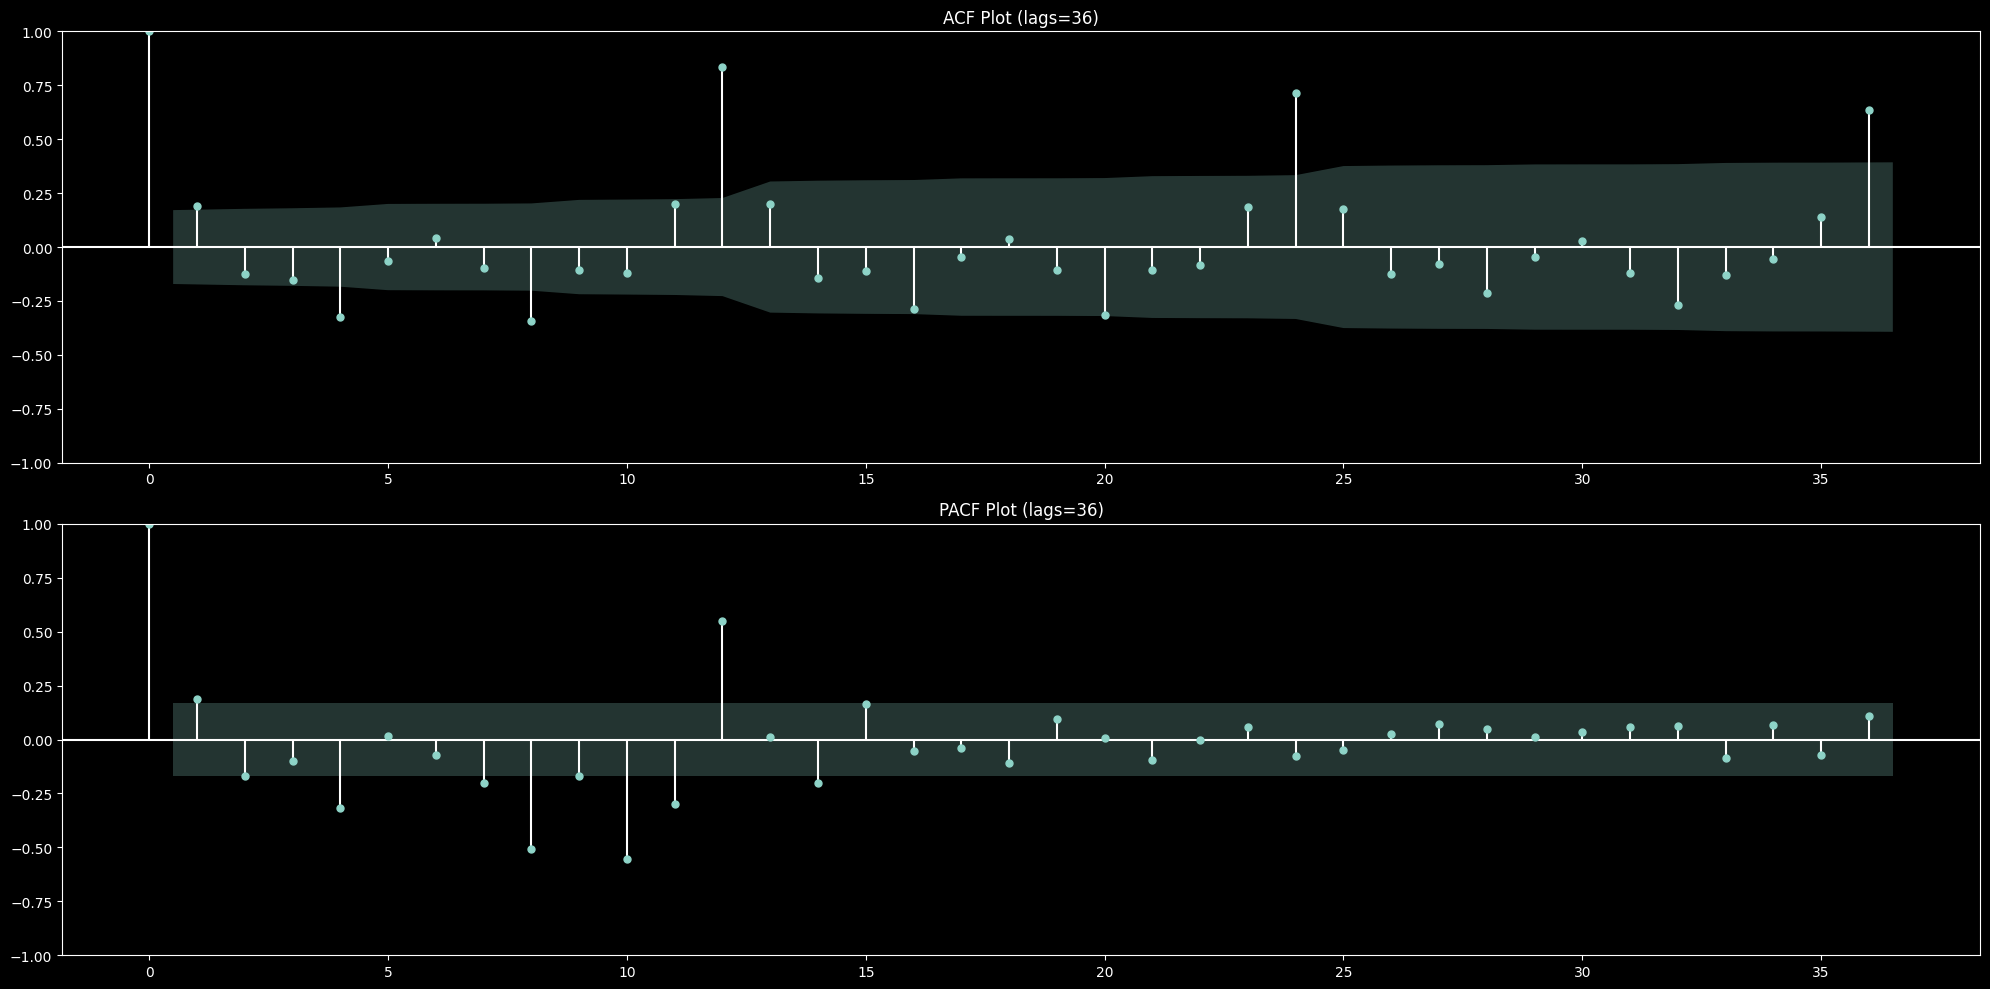

In [147]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def plot_acf_pacf(data, lags, title_suffix=''):
    clean_data = data.dropna()
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))
    plot_acf(clean_data, lags=lags, ax=axes[0])
    axes[0].set_title(f'ACF Plot {title_suffix}')
    plot_pacf(clean_data, lags=lags, ax=axes[1], method='ywm')  # or method='ols'
    axes[1].set_title(f'PACF Plot {title_suffix}')
    plt.tight_layout()
    plt.show()

plot_acf_pacf(ttr['diff1'], lags=12, title_suffix='(lags=12)')
plot_acf_pacf(ttr['diff1'], lags=24, title_suffix='(lags=24)')
plot_acf_pacf(ttr['diff1'], lags=36, title_suffix='(lags=36)')


In [149]:
tr.index = pd.DatetimeIndex(tr.index)
tr.index.freq = pd.infer_freq(tr.index)

model = SARIMAX(endog=tr['Passenger_log'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
result = model.fit()
print(result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                        Passenger_log   No. Observations:                  132
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                 224.954
Date:                              Mon, 26 May 2025   AIC                           -435.907
Time:                                      07:28:23   BIC                           -416.453
Sample:                                  01-01-1949   HQIC                          -428.008
                                       - 12-01-1959                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0283      0.728     -0.039      0.969      -1.456       1.399
ar.L2          0.34

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [150]:
pred_train = result.predict(start=0, end=len(tr) - 1)
pred_train.index = tr.index

start = len(tr)
end = start + len(te) - 1
pred_test = result.predict(start=start, end=end)
pred_test.index = te.index

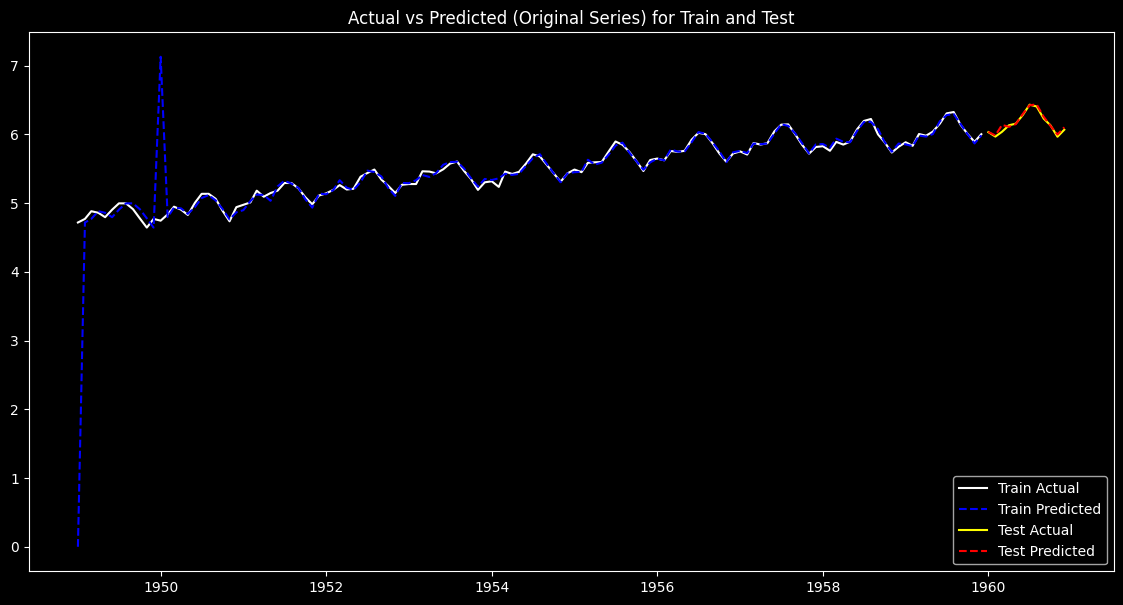

Train MSE: 0.214, MAE: 0.087
Test MSE: 0.001, MAE: 0.025
Train MAPE: 1.76%
Test MAPE: 0.41%


In [151]:
plt.figure(figsize=(14, 7))
plt.plot(tr.index, tr['Passenger_log'], label='Train Actual', color='white')
plt.plot(pred_train.index, pred_train, label='Train Predicted', color='blue', linestyle='--')
plt.plot(te.index, te['Passenger_log'], label='Test Actual', color='yellow')
plt.plot(pred_test.index, pred_test, label='Test Predicted', color='red', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted (Original Series) for Train and Test')
plt.show()

mse_train = mean_squared_error(tr['Passenger_log'], pred_train)
mae_train = mean_absolute_error(tr['Passenger_log'], pred_train)
mse_test = mean_squared_error(te['Passenger_log'], pred_test)
mae_test = mean_absolute_error(te['Passenger_log'], pred_test)

print(f'Train MSE: {mse_train:.3f}, MAE: {mae_train:.3f}')
print(f'Test MSE: {mse_test:.3f}, MAE: {mae_test:.3f}')

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    non_zero = y_true != 0
    return (abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])).mean() * 100

mape_train = mean_absolute_percentage_error(tr['Passenger_log'], pred_train)
mape_test = mean_absolute_percentage_error(te['Passenger_log'], pred_test)

print(f'Train MAPE: {mape_train:.2f}%')
print(f'Test MAPE: {mape_test:.2f}%')